<a href="https://colab.research.google.com/github/ermannomillo/CameraCalibration/blob/main/Camera_Calibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Camera Calibration
### February 2025 - Nicolò Ermanno Millo


### Libraries


In [ ]:
from matplotlib import pyplot as plt
import os
import numpy as np

import cv2 # OpenCV
print (cv2.__version__)

!pip install plotly
import plotly.graph_objects as go

4.10.0


### Load images


In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
GDrivePath = '/content/drive/MyDrive/'
folderpath = GDrivePath + 'Colab Notebooks/CV2024-CameraCalibration/images_webcam/'

import sys
sys.path.append(GDrivePath +'Colab Notebooks/CV2024-CameraCalibration/')
from utils import create_compound_image

Mounted at /content/drive/


In [ ]:
images_path = [os.path.join(folderpath, imagename) for imagename in os.listdir(folderpath) if imagename.endswith(".jpg")]
images_path.sort()
images_path

['/content/drive/MyDrive/Colab Notebooks/CV2024-CameraCalibration/images_webcam/image00.jpg',
 '/content/drive/MyDrive/Colab Notebooks/CV2024-CameraCalibration/images_webcam/image01.jpg',
 '/content/drive/MyDrive/Colab Notebooks/CV2024-CameraCalibration/images_webcam/image02.jpg',
 '/content/drive/MyDrive/Colab Notebooks/CV2024-CameraCalibration/images_webcam/image03.jpg',
 '/content/drive/MyDrive/Colab Notebooks/CV2024-CameraCalibration/images_webcam/image04.jpg',
 '/content/drive/MyDrive/Colab Notebooks/CV2024-CameraCalibration/images_webcam/image05.jpg',
 '/content/drive/MyDrive/Colab Notebooks/CV2024-CameraCalibration/images_webcam/image06.jpg',
 '/content/drive/MyDrive/Colab Notebooks/CV2024-CameraCalibration/images_webcam/image07.jpg',
 '/content/drive/MyDrive/Colab Notebooks/CV2024-CameraCalibration/images_webcam/image08.jpg',
 '/content/drive/MyDrive/Colab Notebooks/CV2024-CameraCalibration/images_webcam/image09.jpg',
 '/content/drive/MyDrive/Colab Notebooks/CV2024-CameraCalibr

### Establishing correspondences


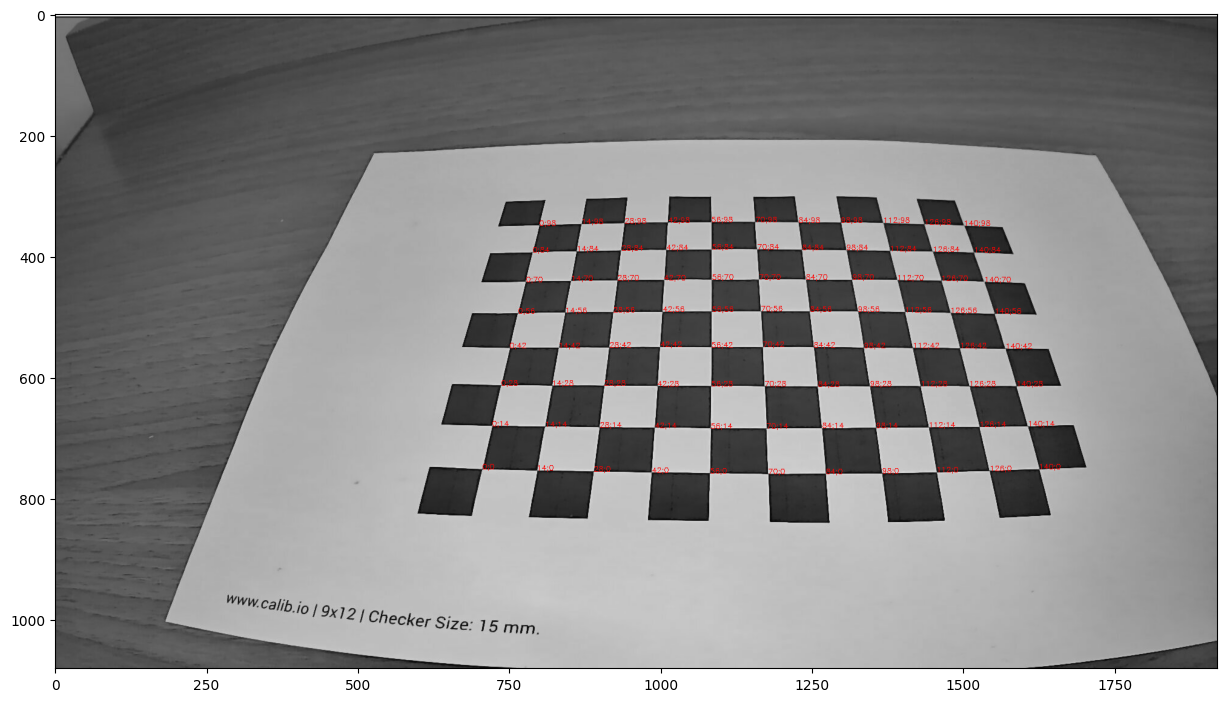

In [ ]:
square_size = 14
grid_size = (8, 11) #the number of corners on each side

filepath = folderpath+ 'image19.jpg'
image = cv2.imread(filepath)
return_value, corners = cv2.findChessboardCorners(image, patternSize=grid_size)
corners = corners.reshape((88,2)).copy()

real_coordinates = np.empty_like(corners)

for index, corner in enumerate(corners):

    u_coord = corner[0] #pxl
    v_coord = corner[1]

    grid_size_cv2 = tuple(reversed(grid_size))
    u_index, v_index = np.unravel_index(index, grid_size_cv2)

    x_mm = (u_index) * square_size
    y_mm = (v_index) * square_size

    real_coordinates[index,:] = [x_mm, y_mm]

    cv2.putText(image, text=f"{x_mm};{y_mm}", org=(round(u_coord),round(v_coord)), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=.4, color=(255,0,0), thickness=1)

plt.figure(figsize=(15, 15))
plt.imshow(image)

## Compute Homographies

In [ ]:
def get_homography(corners):

    """
    Get homography of a checkboard, given its corners
    """

    A = np.empty((0, 9), dtype=float)

    for index, corner in enumerate(corners):

        Xpixel = corners[index, 0]
        Ypixel = corners[index, 1]
        Xmm = real_coordinates[index, 0]
        Ymm = real_coordinates[index, 1]

        m = np.array([Xmm, Ymm, 1]).reshape(1, 3)
        O = np.array([0, 0, 0]).reshape(1, 3)

        A = np.vstack((A, np.hstack((m, O, -Xpixel * m))))
        A = np.vstack((A, np.hstack((O, m, -Ypixel * m))))

    U, S, Vtransposed = np.linalg.svd(A)
    np.linalg.norm( A - U[:,:9]@np.diag(S)@Vtransposed )
    h=Vtransposed.transpose()[:,-1] #keep the last column of V (pay attention to the transposition)
    H = h.reshape(3, 3)

    return H / H[2, 2]

In [ ]:
def get_homographies(corners_dict):

    """
    Get homographies of a set of checkboards, given their corners
    """

    Hst = []

    for i in range(len(corners_dict)):
        H = get_homography(corners_dict[i])
        Hst.append(H)

    return Hst

In [ ]:
corners_dict = []

for p in images_path:
    im = cv2.imread(p)
    return_value, corners_ = cv2.findChessboardCorners(im, patternSize=grid_size, corners=None)
    if not return_value:
        print(f"Pattern not found for image {p}")
    corners=corners_.reshape((88,2)).copy()
    corners_dict.append(corners)

corners_dict_detect = corners_dict

Hst = get_homographies(corners_dict) # List of homographies

## Zhang's method

In [ ]:
def compose_zhang_row(H: np.ndarray, p: int, q: int):

    """
    Compose rows of Zhang's method equations system
    """

    eqs = (
        H[0,p] * H[0,q],
        H[0,p] * H[1,q] + H[1,p] * H[0,q],
        H[1,p] * H[1,q],
        H[2,p] * H[0,q] + H[0,p] * H[2,q],
        H[2,p] * H[1,q] + H[1,p] * H[2,q],
        H[2,p] * H[2,q],
    )
    A = np.array(eqs).reshape(1, 6)
    return A

In [ ]:
def compute_intrinsics( Hst ):

    """
    Compoute Intrinsics from homographies
    """

    N = len(Hst)
    V = np.zeros((2*N, 6))
    for i in range(N):
        H = Hst[i]
        V[2*i,:]   = compose_zhang_row(H, 0, 1)
        V[2*i+1,:] = compose_zhang_row(H, 0, 0) - compose_zhang_row(H, 1, 1)
    U, S, V_T = np.linalg.svd(V)
    b = tuple(V_T[-1])

    B0, B1, B2, B3, B4, B5 = b

    sign = +1
    if B0 < 0 or B2 < 0 or B5 < 0: # Check B negative semi-definite
        sign = -1
    B = sign * np.array([
        [B0, B1, B3],
        [B1, B2, B4],
        [B3, B4, B5],
    ])
    L = np.linalg.cholesky(B)
    K = np.linalg.inv(L.T)
    K /= K[2,2]
    return K


In [ ]:
K = compute_intrinsics(Hst)

## Compute Extrinsics

In [ ]:
def compute_extrinsics(K, Hst):

  """
  Compoute extrinsics given calibration matrix and homographies
  """

  Gst = []
  N = len(Hst)

  for im_idx in range(N):
      Kinv = np.linalg.inv(K)
      H = Hst[im_idx]
      h0 = H[:,0]
      h1 = H[:,1]
      h2 = H[:,2]

      λ = np.linalg.norm(Kinv @ h0)

      r0 = (1 / λ) * Kinv @ h0
      r1 = (1 / λ) * Kinv @ h1
      r2 = np.cross(r0, r1)

      t = (1 / λ) * Kinv @ h2

      R = np.hstack((np.array(r0).reshape(-1, 1), np.array(r1).reshape(-1, 1), np.array(r2).reshape(-1, 1)))

      U, S, V_T = np.linalg.svd(R)
      R = U @ V_T # Closest orthogonal R, respect Frobenious norm

      G = np.eye(4)
      G[:3,:3] = R
      if isinstance(t, np.ndarray):
          t = t.ravel()
      G[:3,3] = t

      Gst.append(G)

  return Gst

In [ ]:

Gst = compute_extrinsics(K, Hst)

## Superimposing Cubes Over the Checkboards

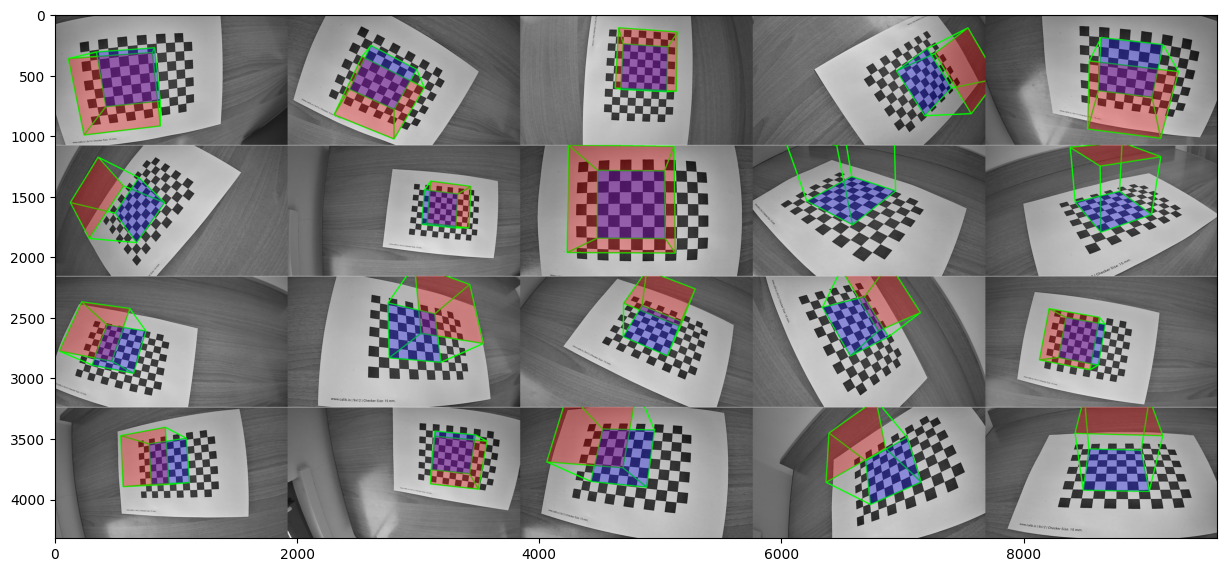

In [ ]:


cube_points = np.array([
    [square_size, square_size, 0],
    [square_size*7, square_size, 0],
    [square_size*7, square_size*7, 0],
    [square_size, square_size*7, 0],
    [square_size, square_size, square_size*6],
    [square_size*7, square_size, square_size*6],
    [square_size*7, square_size*7, square_size*6],
    [square_size, square_size*7, square_size*6]
], dtype=np.float32)


super_cube_images = []

for im_idx in range(len(images_path)):
  image_points = []

  # Project the cube
  for point_world in cube_points:
      point_cam = Gst[im_idx] @ np.append(point_world, 1)
      point_cam /= point_cam[2]
      point_im = K @ np.array([point_cam[0] , point_cam[1], 1])

      image_points.append(point_im[:2] )

  # Load image

  image_points = np.array(image_points)
  im = cv2.imread(images_path[im_idx])

  # Construct and superimpose a cube

  for i in range(0,4):
    cv2.line(im, np.int32(image_points[i]), np.int32(image_points[i+4]), (0,255,0), 10)

  cv2.polylines(im, np.int32([image_points[0:4]]), isClosed=True, color=(0,255,0),thickness=10)
  cv2.polylines(im, np.int32([image_points[4:8]]), isClosed=True, color=(0,255,0),thickness=10)

  alpha = 0.3

  overlay = im.copy()
  cv2.fillPoly(overlay, np.int32([image_points[4:8]]), color=(255, 0,0))
  cv2.addWeighted(overlay, alpha, im, 1 - alpha, 0, im)

  overlay = im.copy()
  cv2.fillPoly(overlay, np.int32([image_points[0:4]]), color=(0, 0,255))
  cv2.addWeighted(overlay, alpha, im, 1 - alpha, 0, im)

  super_cube_images.append(im)

cubes_image=create_compound_image(rows=4,cols=5,limages=super_cube_images)
plt.figure(figsize=(15, 15))
plt.imshow(cubes_image)
plt.show()

## Initial Total Reprojection Error

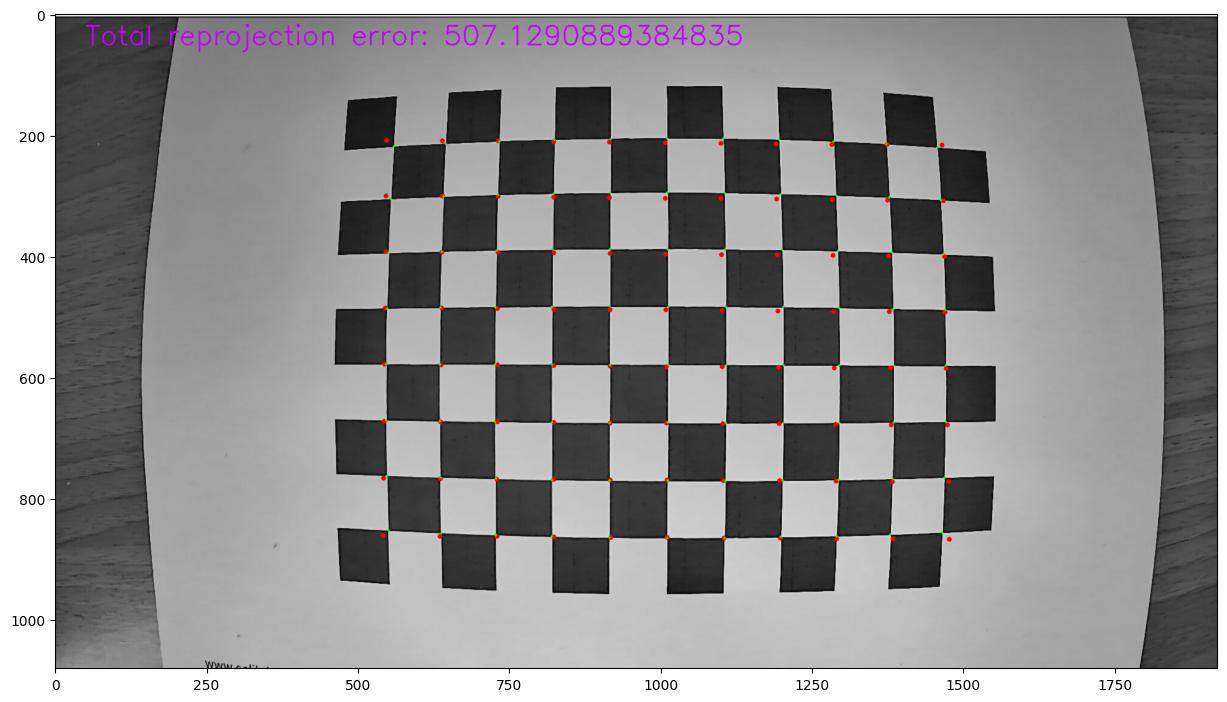

In [ ]:

IM_ID = 7  # Image identifier

image1 = cv2.imread(images_path[IM_ID])

return_value, corners = cv2.findChessboardCorners(image1, patternSize=grid_size)
corners = corners.reshape((88,2)).copy()

tot_reproj_error = 0

for index, corner in enumerate(corners):

    u_coord = corner[0]
    v_coord = corner[1]

    x_mm = real_coordinates[index, 0]
    y_mm = real_coordinates[index, 1]

    point_cam = Gst[IM_ID] @ (x_mm,y_mm, 0, 1)
    point_cam /= point_cam[2]
    point_im = K @ np.array([point_cam[0], point_cam[1], 1])
    point_im /= point_im[2]
    point_im = point_im[:2]

    norm = np.linalg.norm(np.array(corner) - np.array(point_im))
    tot_reproj_error += norm

    cv2.circle(image1, np.int32(point_im.transpose()), radius=0, color=(255,0,0), thickness=7)
    cv2.circle(image1, np.int32(corner), radius=0, color=(0,255,0), thickness=3)

cv2.putText(image1, text=f"Total reprojection error: {tot_reproj_error}", org=(round(50),round(50)), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1.5, color=(200,0,255), thickness=2)

plt.figure(figsize=(15, 15))
plt.imshow(image1)
plt.show()



## Estimate Radial Distortion

In [ ]:
def estimate_k(K, Gst, corners_dict):

  """
  Estimate radial distortion parameters
  """

  M = len(Gst)
  N = len(corners_dict[0])

  c = (K[0, 2], K[1, 2])
  alpha = (K[0,0], K[1, 1])

  D = np.zeros((2 * N * M, 2))
  dp = np.zeros(2 * N * M)
  l = 0

  for i in range(M):

      corners = corners_dict[i]

      for j in range(N):
          u_coord = corners[j, 0]
          v_coord = corners[j, 1]

          x_mm = real_coordinates[j, 0]
          y_mm = real_coordinates[j, 1]

          point_cam = Gst[i] @ np.array([x_mm, y_mm, 0, 1])
          point_cam /= point_cam[2]

          point_im = K @ point_cam[:3]
          point_im /= point_im[2]

          r = np.sqrt(((point_im[0]-c[0])/alpha[0]) ** 2 + ((point_im[1] - c[1])/alpha[1])  ** 2)

          d = (point_im[0] - c[0], point_im[1] - c[1])

          D[2 * l, :] = (d[0] * (r ** 2), d[0] * (r ** 4))
          D[2 * l + 1, :] = (d[1] * (r ** 2), d[1] * (r ** 4))

          dp[2 * l] = u_coord - point_im[0]
          dp[2 * l + 1] = v_coord - point_im[1]

          l += 1

  return  (np.linalg.pinv(D) @ dp)


In [ ]:
k = estimate_k(K, Gst, corners_dict)

## Compensate Radial Distortion

In [ ]:
from scipy.optimize import fsolve

def norm_nonlin_system(x, x_hat, y_hat, k):
    """
    Nonlinear system function for distortion correction.
    """
    r_squared = x[0]**2 + x[1]**2
    radial_distortion = 1 + k[0] * r_squared + k[1] * (r_squared**2)

    F1 = x_hat - x[0] * radial_distortion
    F2 = y_hat - x[1] * radial_distortion
    return [F1, F2]

def compensate(k, K, Gst, corners_dict):

    c = (K[0, 2], K[1, 2])
    alpha = (K[0,0], K[1, 1])
    new_corners = []

    for i in range(len(corners_dict)):

      corners = corners_dict[i]
      comp_corners = []

      for index, corner in enumerate(corners):
          u_coord = corner[0]
          v_coord = corner[1]

          x_mm = real_coordinates[index, 0]
          y_mm = real_coordinates[index, 1]

          point_cam = Gst[i] @ np.array([x_mm, y_mm, 0, 1])
          point_cam /= point_cam[2]
          point_im = K @ np.array([point_cam[0] , point_cam[1], 1])
          point_im /= point_im[2]

          x_hat = (u_coord - c[0]) / alpha[0]
          y_hat = (v_coord - c[1]) / alpha[1]

          x0 = (point_im[0] - c[0]) / alpha[0]
          y0 = (point_im[1] - c[1]) / alpha[1]

          X_solution = fsolve(norm_nonlin_system, [x0, y0], args=(x_hat, y_hat, k))

          comp_u = X_solution[0] * alpha[0] + c[0]
          comp_v = X_solution[1] * alpha[1] + c[1]

          comp_corners.append((comp_u, comp_v ))

      new_corners.append(np.array(comp_corners))

    return new_corners



## Iterative Camera Calibration Refinement

In [ ]:
iteration = 1

DKst = []
Dkst = []
Dk = 100
DK = 100


while(iteration < 1500 and Dk > 1e-15 and DK > 1e-15   ):
  corners_dict = compensate(k, K, Gst, corners_dict)
  Hst = get_homographies(corners_dict)
  former_K = K
  K = compute_intrinsics(Hst)
  Gst = compute_extrinsics(K, Hst)
  former_k = k
  k = estimate_k(K, Gst, corners_dict)


  Dk = np.linalg.norm(former_k-k)
  DK = np.linalg.norm(former_K-K)

  DKst.append(DK)
  Dkst.append(Dk)

  iteration +=1
  if (iteration % 200 == 0):
    print(f"Iteration: {iteration}")


Iteration: 200
Iteration: 400
Iteration: 600
Iteration: 800
Iteration: 1000
Iteration: 1200
Iteration: 1400


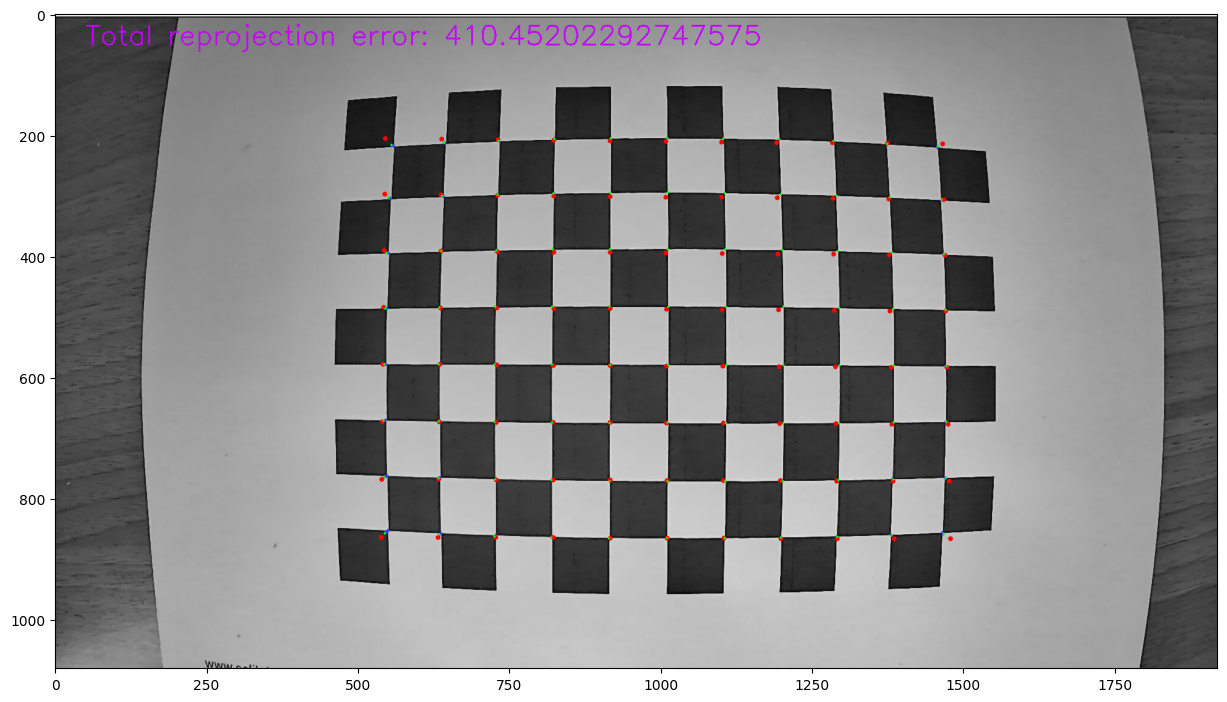

In [ ]:

image1 = cv2.imread(images_path[IM_ID])

corners_detect = corners_dict_detect[IM_ID]

corners=corners_dict[IM_ID]

tot_reproj_error = 0

for index, corner in enumerate(corners):

    u_coord = corner[0]
    v_coord = corner[1]

    u_index, v_index = np.unravel_index(index, grid_size_cv2)
    x_mm = (u_index) * square_size
    y_mm = (v_index) * square_size

    point_cam = Gst[IM_ID] @ np.array([x_mm, y_mm, 0, 1])
    point_cam /= point_cam[2]
    point_im = K @ point_cam[:3]
    point_im /= point_im[2]
    point_im = point_im[:2]

    norm = np.linalg.norm(np.array(corner) - np.array(point_im))
    tot_reproj_error += norm

    cv2.line(image1, tuple(map(int, corner)), tuple(map(int, corners_detect[index])), color=(60, 60, 255), thickness=3)

    cv2.circle(image1, tuple(map(int, point_im.transpose())), radius=0, color=(255,0,0), thickness=7)
    cv2.circle(image1, tuple(map(int, corner)), radius=0, color=(0,255,0), thickness=3)

cv2.putText(image1, text=f"Total reprojection error: {tot_reproj_error}", org=(round(50),round(50)), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1.5, color=(200,0,255), thickness=2)

plt.figure(figsize=(15, 15))
plt.imshow(image1)
plt.show()


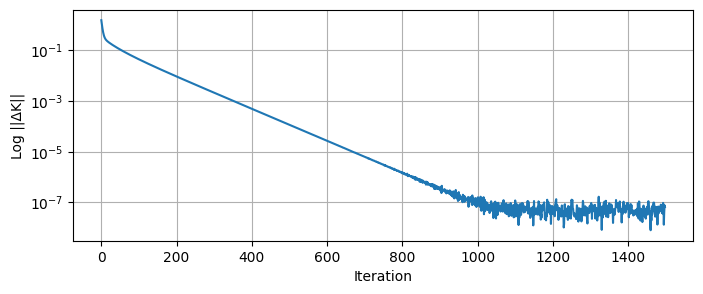

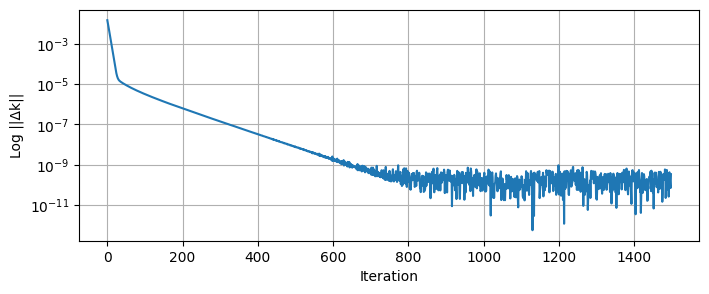

In [ ]:
plt.figure(figsize=(8, 3))
plt.plot(DKst)
plt.yscale('log')
plt.xlabel("Iteration")
plt.ylabel("Log ||ΔK||")
plt.grid()
plt.show()

plt.figure(figsize=(8, 3))
plt.plot(Dkst)
plt.yscale('log')
plt.xlabel("Iteration")
plt.ylabel("Log ||Δk||")
plt.grid()
plt.show()

In [ ]:

xpoints = np.linspace(-0.5, 0.5, 100)
y = np.linspace(-0.5, 0.5, 100)

X, Y = np.meshgrid(xpoints, y)

# radial distance from the origin
R = np.sqrt(X**2 + Y**2)

Z = k[0] * (R**2) + k[1] * (R**4)

fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y)])

fig.update_layout(
    title="",
    scene=dict(
        xaxis_title='u',
        yaxis_title='v',
        zaxis_title='D(r,k)'
    ),
    autosize=True
)

fig.show()
